In [2]:
import pandas as pd
from postprocess.error_distribution import histograms_to_biais_rmse
from postprocess.skill_scores import compute_all_scores
def compute_unc_results_df(metrics_dict):
    reduced_datasets = []
    for dataset in metrics_dict.values():
        reduced_datasets.append(histograms_to_biais_rmse(dataset.groupby('time.month').sum()))
    concatenated = xr.concat(reduced_datasets, pd.Index([prod.plot_name for prod in product_list], name="product"), coords="minimal")
    reduced_df = concatenated.to_dataframe().reset_index('product')
    return reduced_df

def compute_conf_results_df(metrics_dict):
    reduced_datasets = []
    for dataset in metrics_dict.values():
        tp, tn, fp, fn = (
            dataset.data_vars["true_positive"].sum(),
            dataset.data_vars["true_negative"].sum(),
            dataset.data_vars["false_positive"].sum(),
            dataset.data_vars["false_negative"].sum(),
        )
        scores = compute_all_scores(dataset.groupby('time.month').sum())
        scores = scores.assign({'total_count': tp+tn+fp+fn})
        reduced_datasets.append(scores)

    concatenated = xr.concat(reduced_datasets, pd.Index([prod.plot_name for prod in product_list], name="product"), coords="minimal")
    reduced_df = concatenated.to_dataframe().reset_index('product')
    return reduced_df

In [1]:
import xarray as xr
from products.snow_cover_product import MeteoFranceSNPPPrototype, VNP10A1, VJ110A1
from postprocess.general_purpose import open_reduced_dataset, open_reduced_dataset_for_plot

analysis_folder = '/home/imperatoren/work/VIIRS_S2_comparison/viirsnow/output_folder/version_8/'
product_list = [ VNP10A1()]

/home/imperatoren/work/VIIRS_S2_comparison/viirsnow/src/postprocess/general_purpose.py:102: SyntaxWarning: invalid escape sequence '\>'
  "slope_bins": np.array(["[0-10]", "[11-30]", "\>30"], dtype=str),
/home/imperatoren/work/VIIRS_S2_comparison/viirsnow/src/postprocess/general_purpose.py:103: SyntaxWarning: invalid escape sequence '\>'
  "sensor_zenith_bins": np.array(["[0-15]", "[15-30]", "[30-45]", "[45-60]", "\>60"], dtype=str),
/home/imperatoren/work/VIIRS_S2_comparison/viirsnow/src/postprocess/general_purpose.py:118: SyntaxWarning: invalid escape sequence '\%'
  "ref_bins": "Ref FSC [\%]",


<>:46: SyntaxWarning: invalid escape sequence '\%'
<>:46: SyntaxWarning: invalid escape sequence '\%'
/tmp/ipykernel_58958/2128036194.py:46: SyntaxWarning: invalid escape sequence '\%'
  params = ["View Zenith Angle [°]", "Ref FSC [\%]", "Aspect", "Landcover", "Slope [°]"]


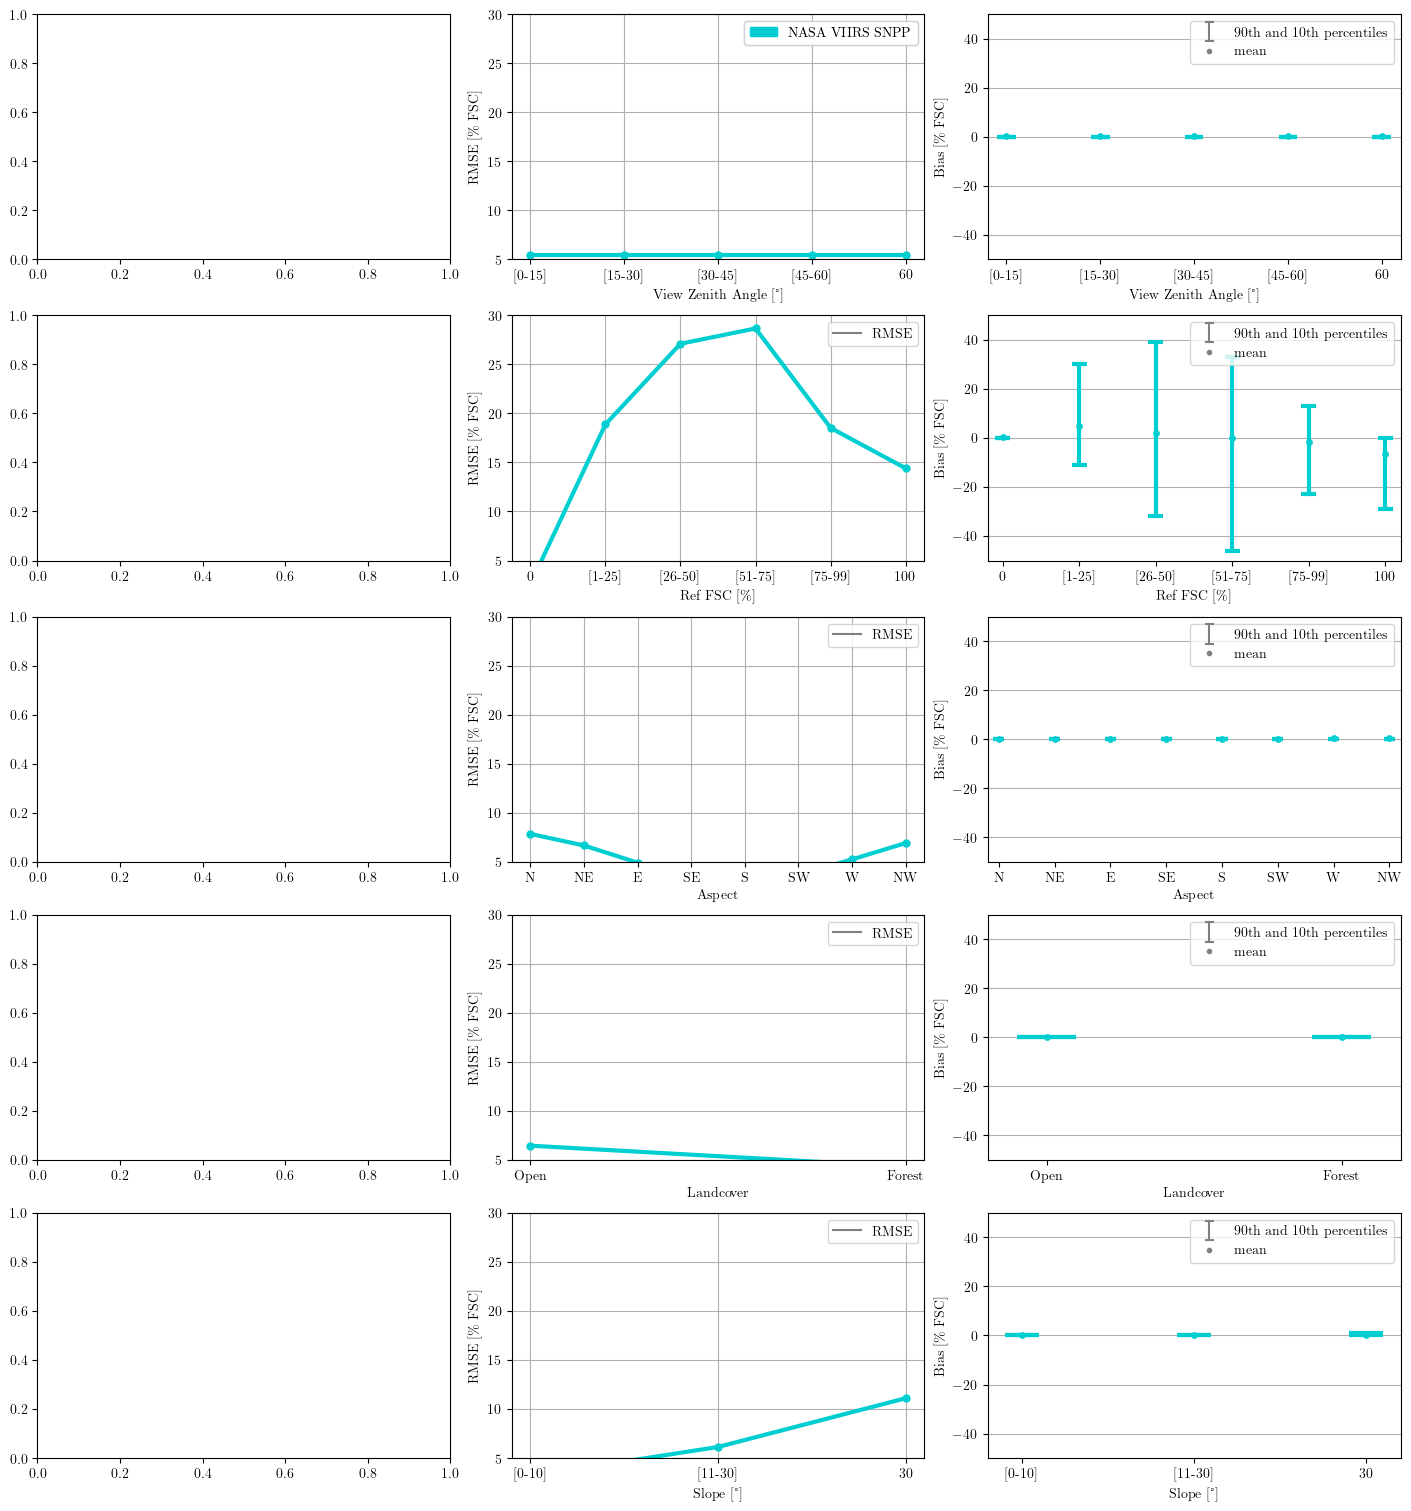

In [ ]:
from typing import List
from matplotlib import pyplot as plt
from matplotlib.axes import Axes
from postprocess.error_distribution import line_plot_rmse, plot_custom_spans
# from postprocess.skill_scores import line_plot_accuracy_f1_score
import matplotlib.patches as mpatches
from typing import Dict
from products.snow_cover_product import SnowCoverProduct



def plot_product_legend(snow_cover_products: List[SnowCoverProduct],legend_ax: Axes):
    custom_leg = [
            mpatches.Patch(color=product.plot_color, label=product.plot_name)
            for product in snow_cover_products
        ]
        
    product_legend =legend_ax.legend(handles=custom_leg, loc='best')
    legend_ax.add_artist(product_legend)

def plot_one_var_analysis(snow_cover_products: List[SnowCoverProduct],analysis_folder: str, analysis_var:str, axs: List[Axes]):
    if analysis_var=="View Zenith Angle [°]":
        # line_plot_accuracy_f1_score(metrics_dict_conf={MF_NO_FOREST_RED_BAND_SCREEEN_VAR_NAME:metrics_dict_conf[MF_NO_FOREST_RED_BAND_SCREEEN_VAR_NAME]}, analysis_var=analysis_var,ax=axs[0])
        plot_custom_spans(snow_cover_products=snow_cover_products, analysis_folder=analysis_folder, analysis_var=analysis_var, ax=axs[2])
        line_plot_rmse(snow_cover_products=snow_cover_products, analysis_folder=analysis_folder, analysis_var=analysis_var,ax=axs[1])
    else:
        # line_plot_accuracy_f1_score(metrics_dict_conf, analysis_var=analysis_var,ax=axs[0])
        line_plot_rmse(snow_cover_products=snow_cover_products, analysis_folder=analysis_folder, analysis_var=analysis_var,ax=axs[1])
        plot_custom_spans(snow_cover_products=snow_cover_products, analysis_folder=analysis_folder,analysis_var=analysis_var, ax=axs[2])
def plot_grid(snow_cover_products: List[SnowCoverProduct],analysis_folder: str, params_list:List[str], axs: List[Axes]):
    for i, var in enumerate(params_list):
        if var=="View Zenith Angle [°]":
            plot_one_var_analysis(snow_cover_products=snow_cover_products, 
                                  analysis_folder=analysis_folder,
                                  analysis_var=var,
                                  axs=axs[i])
        else:
            plot_one_var_analysis(snow_cover_products, analysis_folder, var,axs[i])


plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif"
})
params = ["View Zenith Angle [°]", "Ref FSC [\%]", "Aspect", "Landcover", "Slope [°]"] 
# params =  ["ref_bins", "aspect_bins"]#,"Landcover", "Aspect", "Slope [°]"] 
fig, axs = plt.subplots(len(params), 3, figsize=(14,3  * len(params)), layout="constrained")
plot_grid(snow_cover_products=product_list,analysis_folder=analysis_folder,params_list=params, axs=axs)
plot_product_legend(snow_cover_products=product_list, legend_ax=axs[0,1])
# fig.savefig('/home/imperatoren/work/VIIRS_S2_comparison/article/illustrations/synthesis_scores_plot.png', format='png',bbox_inches='tight')

In [ ]:
import numpy as np

from postprocess.general_purpose import open_reduced_dataset_completeness
from products.snow_cover_product import MeteoFranceSNPPPrototype, SnowCoverProduct, VNP10A1, VJ110A1
import xarray as xr
from matplotlib import pyplot as plt
from postprocess.error_distribution import histograms_to_biais_rmse

analysis_type = "completeness"
analysis_folder = (
    "/home/imperatoren/work/VIIRS_S2_comparison/viirsnow/output_folder/version_8/"
)

product_list = [ MeteoFranceSNPPPrototype(),VNP10A1(),  VJ110A1() ]


def open_reduced_dataset(product: SnowCoverProduct, analysis_folder: str, analysis_type: str):
    return xr.open_dataset(
        f"{analysis_folder}/analyses/{analysis_type}/{analysis_type}_WY_2023_2024_{product.name}_vs_S2_theia.nc"
    )



analyses_dict_uncertainty= {}
for product in product_list:
    analyses_dict_uncertainty.update({product: open_reduced_dataset(product=product, analysis_folder=analysis_folder, analysis_type='uncertainty')}) 

analyses_dict_completeness= {}
for product in product_list:
    analyses_dict_completeness.update({product: open_reduced_dataset_completeness(product=product, analysis_folder=analysis_folder, analysis_type='completeness')}) 

metrics_dict_completeness = {k:v.sel(time=slice('2023-11', '2024-06'), altitude_bins=slice(900, None)).sum(dim=( 'altitude_bins'))  for k,v in analyses_dict_completeness.items()}
for k,v in metrics_dict_completeness.items():
    if 'forest_mask_bins' in v.dims:
        metrics_dict_completeness.update({k: v.sum(dim=( 'forest_mask_bins'))})


metrics_dict_unc= {k:v.sel(time=slice('2023-11', '2024-06'), altitude_bins=slice(900, None)).sum(dim=('ref_bins', 'altitude_bins')) for k,v in analyses_dict_uncertainty.items()}


metrics_dict_unc = {k:v.resample({"time": "1ME"}).sum(dim="time") for k,v in analyses_dict_uncertainty.items()}
metrics_dict_unc = {k:v.groupby("time").map(histograms_to_biais_rmse) for k,v in metrics_dict_unc.items()}

In [11]:
import numpy as np

from postprocess.general_purpose import open_reduced_dataset_completeness
from products.snow_cover_product import MeteoFranceJPSS1Prototype, MeteoFranceJPSS2Prototype, MeteoFranceMultiplatformPrototype, MeteoFranceSNPPPrototype, SnowCoverProduct
import xarray as xr
from matplotlib import pyplot as plt
from postprocess.error_distribution import histograms_to_biais_rmse

analysis_type = "completeness"
analysis_folder = (
    "/home/imperatoren/work/VIIRS_S2_comparison/viirsnow/output_folder/version_8/"
)

product_list = [ MeteoFranceSNPPPrototype(),MeteoFranceJPSS1Prototype(),  MeteoFranceJPSS2Prototype(),MeteoFranceMultiplatformPrototype(), ]


def open_reduced_dataset(product: SnowCoverProduct, analysis_folder: str, analysis_type: str):
    return xr.open_dataset(
        f"{analysis_folder}/analyses/{analysis_type}/{analysis_type}_WY_2023_2024_{product.name}_vs_S2_theia.nc"
    )



analyses_dict_uncertainty= {}
for product in product_list:
    analyses_dict_uncertainty.update({product: open_reduced_dataset(product=product, analysis_folder=analysis_folder, analysis_type='uncertainty')}) 

analyses_dict_completeness= {}
for product in product_list:
    analyses_dict_completeness.update({product: open_reduced_dataset_completeness(product=product, analysis_folder=analysis_folder, analysis_type='completeness')}) 

metrics_dict_completeness = {k:v.sel(time=slice('2023-11', '2024-06'), altitude_bins=slice(900, None)).sum(dim=( 'altitude_bins'))  for k,v in analyses_dict_completeness.items()}
for k,v in metrics_dict_completeness.items():
    if 'forest_mask_bins' in v.dims:
        metrics_dict_completeness.update({k: v.sum(dim=( 'forest_mask_bins'))})


metrics_dict_unc= {k:v.sel(time=slice('2023-11', '2024-06'), altitude_bins=slice(900, None)).sum(dim=('ref_bins', 'altitude_bins')) for k,v in analyses_dict_uncertainty.items()}


metrics_dict_unc = {k:v.resample({"time": "1ME"}).sum(dim="time") for k,v in analyses_dict_uncertainty.items()}
metrics_dict_unc = {k:v.groupby("time").map(histograms_to_biais_rmse) for k,v in metrics_dict_unc.items()}

In [ ]:

from matplotlib import patches, ticker
from typing import Dict, List
from matplotlib.axes import Axes

def annual_area_fancy_plot(
    metrics_dict_completeness: Dict[SnowCoverProduct, xr.Dataset],
    metrics_dict_uncertainty: Dict[SnowCoverProduct, xr.Dataset],
    axs: List[Axes] | None = None,
):
    # if len(metrics_dict_completeness) > 1:
    #     common_days = np.intersect1d(*[v.coords["time"] for v in metrics_dict_completeness.values()][:2])
    
    # if len(metrics_dict_completeness) > 2:
    #     for k,v in metrics_dict_completeness.items():
    #         if 'jpss2' not in k.name:
    #             common_days = np.intersect1d(common_days, v.coords["time"])


    [ax.set_ylabel("Area [km²]") for ax in axs[:1]]
    axs[1].set_ylabel("RMSE [\% FSC]")
    custom_leg = [
        patches.Patch(color=product.plot_color, label=product.plot_name)
        for product in metrics_dict_completeness
    ]
    product_legend = axs[0].legend(handles=custom_leg, loc=[0.8, 0.45])
    axs[0].add_artist(product_legend)
    old_snow_cover=0
    for product in metrics_dict_completeness:
        metrics_dict_completeness[product] = metrics_dict_completeness[product]#.sel(time=common_days)
        product_monthly_averages = (
            metrics_dict_completeness[product].resample({"time": "1ME"}).mean(dim="time").data_vars["surface"] * 1e-6
        )

        snow_cover = product_monthly_averages.sel(class_name="snow_cover")
        time_ax=np.arange(metrics_dict_uncertainty[product].sizes["time"])
        if 'jpss2' in product.name:
            time_ax=time_ax+6

        axs[0].fill_between(
            time_ax,
            snow_cover,
            old_snow_cover,
            alpha=0.5,
            color=product.plot_color,
        )

        axs[1].plot(
            time_ax,
            metrics_dict_uncertainty[product].rmse,
            '^-',
            color=product.plot_color,
            lw=2,
        )

    axs[0].yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0e}"))
    axs[1].set_ylim(0, 20)
    axs[1].grid()
    axs[0].set_title("Snow cover")
    axs[1].set_title("RMSE")
    axs[1].set_xticks(np.arange(product_monthly_averages.sizes["time"]))
    axs[1].set_xticklabels(product_monthly_averages.coords["time"].to_dataframe().index.strftime("%B"))



<>:20: SyntaxWarning: invalid escape sequence '\%'
<>:20: SyntaxWarning: invalid escape sequence '\%'
/tmp/ipykernel_41698/1898438044.py:20: SyntaxWarning: invalid escape sequence '\%'
  axs[1].set_ylabel("RMSE [\% FSC]")


<Figure size 640x480 with 0 Axes>

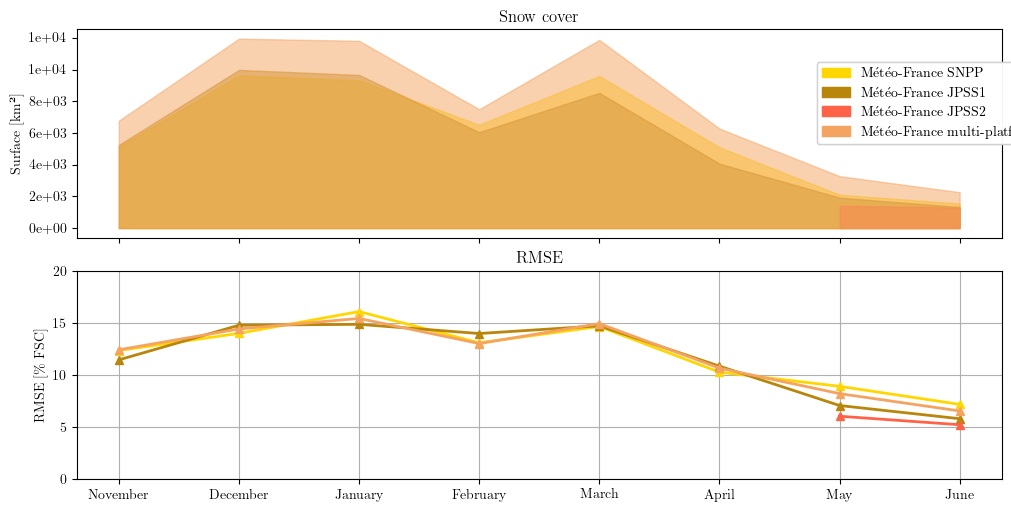

In [ ]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif"
})

plt.subplots_adjust(bottom=0.18)
fig, axs = plt.subplots(2, 1, figsize=(10, 5), sharex=True, layout="constrained")
annual_area_fancy_plot(metrics_dict_completeness=metrics_dict_completeness,metrics_dict_uncertainty=metrics_dict_unc, axs=axs)
# fig.savefig('/home/imperatoren/work/VIIRS_S2_comparison/article/illustrations/multiplatform_composite.png', format='png',bbox_inches='tight')


In [12]:
import xarray as xr

ds = xr.open_dataset('/home/imperatoren/work/VIIRS_S2_comparison/viirsnow/output_folder/version_8/analyses/completeness/completeness_WY_2023_2024_nasa_l3_snpp.nc')
ds= ds.sel(time=slice('2023-11', '2024-06'))
snow_cover = ds.data_vars['surface'].sel(class_name='snow_cover').sum(dim=('altitude_bins', 'time', 'forest_mask_bins'))
total = ds.data_vars['surface'].sel(class_name=['snow_cover', 'no_snow', 'water']).sum()
print(snow_cover/total*100)

<xarray.DataArray 'surface' ()> Size: 8B
array(20.56430007)
Coordinates:
    class_name  <U10 40B 'snow_cover'


In [ ]:

ds = xr.open_dataset('/home/imperatoren/work/VIIRS_S2_comparison/viirsnow/output_folder/version_8/analyses/completeness/completeness_WY_2023_2024_nasa_l3_snpp.nc')
ds= ds.sel(altitude_bins=slice(900,None), time=slice('2023-11', '2024-06'))
snow_cover = ds.data_vars['surface'].sel(class_name='snow_cover').sum(dim=('altitude_bins', 'time', 'forest_mask_bins'))
total = ds.data_vars['surface'].sel(class_name=['snow_cover', 'no_snow', 'water']).sum()
print(snow_cover/total*100)

<xarray.DataArray 'surface' ()> Size: 8B
array(31.43190877)
Coordinates:
    class_name  <U10 40B 'snow_cover'
